### Load Model Samples

In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.journal_run.model_load.load_ssn import load_ssn
from trustworthai.journal_run.model_load.load_punet import load_p_unet
from trustworthai.journal_run.model_load.load_deterministic import load_deterministic
from trustworthai.journal_run.model_load.load_evidential import load_evidential
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

# optimizer and lr scheduler
import torch


import numpy as np
from tqdm import tqdm
import scipy.stats
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

import pandas as pd
from trustworthai.analysis.connected_components.connected_comps_2d import conn_comp_2d_analysis
from trustworthai.analysis.evaluation_metrics.challenge_metrics import getAVD, getDSC, getHausdorff, getLesionDetection, do_challenge_metrics
from sklearn import metrics
import math

import torch
import matplotlib.pyplot as plt
from trustworthai.utils.plotting.saving_plots import save
from trustworthai.utils.print_and_write_func import print_and_write
from trustworthai.analysis.calibration.helper_funcs import *
from tqdm import tqdm
from trustworthai.utils.logits_to_preds import normalize_samples

# data
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples


# evaluation code
from trustworthai.journal_run.evaluation.new_scripts.eval_helper_functions import *
from trustworthai.journal_run.evaluation.new_scripts.model_predictions import *
from trustworthai.analysis.connected_components.connected_comps_2d import *
print("banana")


strawberry
running on local machine!
banana


In [2]:
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

In [3]:
ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [02:17<00:00,  2.11it/s]


In [4]:
models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"

In [10]:
import matplotlib.pyplot as plt
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write
import pandas as pd

In [11]:
#samples[0].shape

In [12]:
from torch.utils.data import Dataset

class LimitedSizeDataset(Dataset):
    def __init__(self, base_dataset, start, end):
        super().__init__()
        self.base_dataset = base_dataset
        self.start = start
        self.end = end
        
    def __len__(self):
        return self.end - self.start
    
    def __getitem__(self, idx):
        if idx + self.start >= self.end:
            raise IndexError
        return self.base_dataset[idx + self.start]

In [13]:
start = 260
end = 300

In [14]:
ds = LimitedSizeDataset(ADNI_ds, start=start, end=end)

In [15]:
IDs = ADNI_ds.getIDs()[start:end]

In [16]:
len(ds)

40

In [17]:
stride = 1

In [18]:
means, samples, test_datasets = generate_means_and_samples_SSN_Ens_Efficient(ds, dataset_stride=stride, temp=1, num_samples=10)

size:  40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.80it/s]


In [19]:
len(means), len(samples)

(30, 30)

In [20]:
# softmax entropy
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=True) for scan_index in range(len(means))]

# evidential
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=False) for scan_index in range(len(means))]

# other methods
ent_maps = [entropy_map_from_samples(samples[scan_index]) for scan_index in range(len(means))]

In [21]:
def var_map_from_samples(samples):
    samples = torch.softmax(samples.cuda(), dim=2)[:,:,1]
    return torch.var(samples, dim=0).cpu()

In [22]:
var_maps = [var_map_from_samples(samples[scan_index]) for scan_index in tqdm(range(len(means)), position=0, leave=True)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.91it/s]


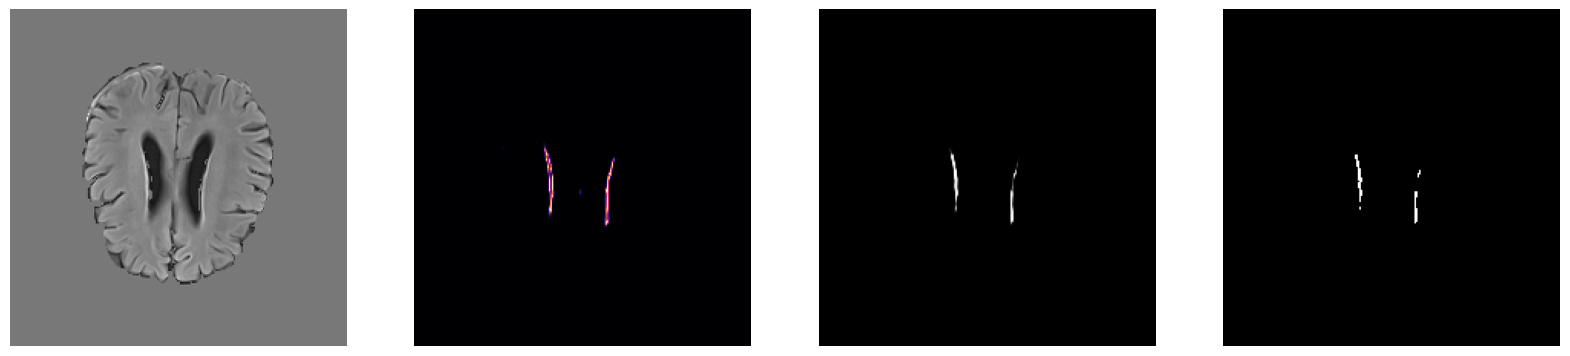

In [23]:
pos = 0
islice = 35
plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
plt.imshow(ds[pos][0][islice], cmap='gray'); plt.axis('off');
plt.subplot(1,4,2)
plt.imshow(ent_maps[pos][islice], cmap='magma'); plt.axis('off');
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(means[pos][islice], dim=0)[1], cmap='gray'); plt.axis('off');
plt.subplot(1,4,4)
plt.imshow(means[pos][islice].argmax(dim=0), cmap='gray'); plt.axis('off');

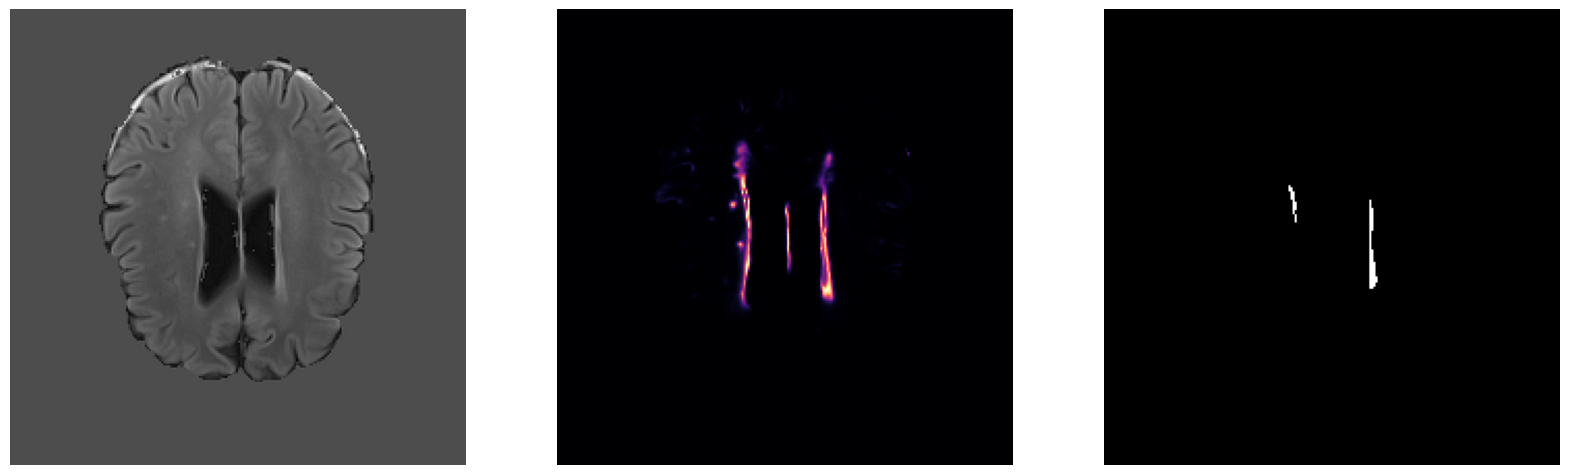

In [24]:
pos = 4
islice = 35
plt.figure(figsize=(20, 8))
plt.subplot(1,3,1)
plt.imshow(ds[pos][0][islice], cmap='gray'); plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(ent_maps[pos][islice], cmap='magma'); plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(means[pos][islice].argmax(dim=0), cmap='gray'); plt.axis('off');

In [25]:
len(IDs), len(ent_maps)

(30, 30)

In [26]:
import numpy as np

In [27]:
output_dir = "/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/"
model_name = "SSN_Ens"

try:
    os.makedirs(output_dir + model_name)
except FileExistsError:
    print("folder already exists")

# if len(os.listdir(output_dir + model_name)) > 0:
#     raise ValueError("directory is not empty")
# else:
#     print("good, empty folder")

folder already exists


In [28]:
model_name

'SSN_Ens'

In [29]:
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    var = var_maps[i]
    ent = ent_maps[i]
    pred = torch.nn.functional.softmax(means[i].cuda(), dim=1)[:,1]
    seg = (pred > 0.5)
    np.savez_compressed(f"{output_dir}{model_name}/{ID}_out_maps.npz", var=var, ent=ent, pred=pred.cpu(), seg=seg.cpu())
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:27<00:00,  2.91s/it]
